In [23]:
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder as OHE
from sklearn.preprocessing import LabelEncoder


from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,confusion_matrix
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer


from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

In [24]:
df = pd.read_csv('Datasets/Cleaned_Tweets.csv')

In [25]:
df.head()

,airline_sentiment,text
0,neutral,said
1,positive,plus youve added commercial experience tacky
2,neutral,didnt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


In [26]:
df.shape

(14640, 2)

In [27]:
df['airline_sentiment'].value_counts()

airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

In [28]:
df['text'].isnull().sum()

21

In [29]:
# drop null values
df = df.dropna()

In [30]:
df['text'].isnull().sum()

0

In [31]:
# 2) Tokenize and pad
num_words = 12755
tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
tokenizer.fit_on_texts(df['text'])  
sequences = tokenizer.texts_to_sequences(df['text'])
maxlen = 15

In [32]:
X = pad_sequences(sequences, maxlen=maxlen, padding='post')
y = df['airline_sentiment']

In [33]:
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

In [34]:
le = LabelEncoder()
y = le.fit_transform(y)

In [35]:
y= tf.keras.utils.to_categorical(y)

In [36]:
y.shape 

(7080, 3)

In [37]:
# Save the categories into a list 
categories = list(np.unique(df['airline_sentiment']))       
categories

['negative', 'neutral', 'positive']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
print(X_train.shape, X_test.shape)  

(5664, 15) (1416, 15)


In [40]:
learning_rate = 0.1

sgd = SGD(learning_rate=learning_rate)
# Build model
model= Sequential()
model.add(Embedding(input_dim=num_words, output_dim=maxlen),)
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

In [41]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])


In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    batch_size=64,
    validation_split=(0.2),
    epochs=50,
    callbacks=[early_stop]
)

Epoch 1/50


71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.3352 - loss: 1.0989 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.3416 - val_loss: 1.0970 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3684 - loss: 1.0949 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.4025 - val_loss: 1.0906 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3911 - loss: 1.0864 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_accuracy: 0.4016 - val_loss: 1.0780 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4272 - loss: 1.0699 - precision_2: 0.1714 - recall_2: 8.3204e-04 - val_accuracy: 0.3963 - val_loss: 1.0633 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/50
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4408 - loss: 1.0497 - 

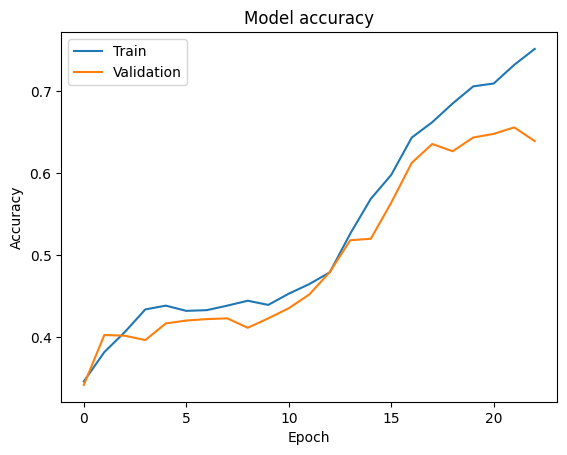

In [46]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
y_proba = model.predict(X_test)  

y_pred = np.argmax(y_proba, axis=1) 

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [49]:
y_test = np.argmax(y_test, axis=1)  

In [51]:
print('Classification Report:\n', classification_report(y_test, y_pred, target_names=categories))
    

Classification Report:
               precision    recall  f1-score   support

    negative       0.72      0.77      0.75       498
     neutral       0.55      0.60      0.57       443
    positive       0.78      0.65      0.71       475

    accuracy                           0.68      1416
   macro avg       0.68      0.68      0.68      1416
weighted avg       0.69      0.68      0.68      1416

